# Configuración del notebook

### Declare libraries that i am going to use

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import pandas as pd
pd.set_option("display.max_columns", 30)
import numpy as np
# librerías para análisis estadístico
import scipy as sp
# librerías para graficar
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="white")
import os
import time
from datetime import datetime

### set the working directory of my local 

In [2]:
# you need to change it if you are going to run it on your local machine, writing the folder where the raw data of the challenge is
os.chdir('/Users/iairlinker/Documents/repos/challenge - cornershop/data')

### declare functions made by me that i am going to use

In [3]:
# función creada por mi para traer los NA's
def get_na(df):
    qsna=df.shape[0]-df.isnull().sum(axis=0)
    qna=df.isnull().sum(axis=0)
    ppna=round(100*(df.isnull().sum(axis=0)/df.shape[0]),2)
    aux= {'datos sin NAs en q': qsna, 'Na en q': qna ,'Na en %': ppna}
    na=pd.DataFrame(data=aux)
    return na.sort_values(by='Na en %',ascending=False)

## función creada por mi para extraer las medidas de tendencia central en valores agrupados
def get_measure_central_tendency(df,constant_variable,explanatory_variable, metric):
    avg = df.groupby([explanatory_variable])[metric].mean().reset_index()
    avg.rename(columns=({metric:'mean'}), inplace=True)
    std = df.groupby([explanatory_variable])[metric].std().reset_index()
    std.rename(columns=({metric:'std'}), inplace=True)
    median = df.groupby([explanatory_variable])[metric].median().reset_index()
    median.rename(columns=({metric:'median'}), inplace=True)
    # con esto obtengo la cantidad de órdenes por comuna
    quantity = df.groupby(explanatory_variable)[constant_variable].nunique().reset_index()
    quantity.rename(columns=({constant_variable:'quantity'}), inplace=True)
    aux = pd.merge(avg, std, how='left', on=explanatory_variable)
    aux = pd.merge(aux, median, how='left', on=explanatory_variable)
    aux = pd.merge(aux, quantity, how='left', on=explanatory_variable).sort_values(by='quantity', ascending=True).reset_index(drop=True)
    aux['coef_var_pearson'] = aux['std'] / aux['mean']
    del avg, std, median
    aux['cumsum_quantity'] = aux.quantity.cumsum()
    aux['cumsum_quantity_pp'] = aux['cumsum_quantity']/ df[constant_variable].shape[0]
    return aux

## función creada por mi para extraer las medidas de tendencia central en valores agrupados cuando quiero agrupar por 2 variables
def get_get_measure_central_tendency_2(df,constant_variable,explanatory_variable1,explanatory_variable2, metric):
    # acá obtengo la cantidad promedio y mediana que solicitan de cada producto
# También agrego las desviaciones estándar de los promedios para validar si el promedio es representativo
    avg = order_products.groupby([explanatory_variable1,explanatory_variable2])[metric].mean().reset_index()
    avg.rename(columns=({metric:'mean'}), inplace=True)
    std = order_products.groupby([explanatory_variable1,explanatory_variable2])[metric].std().reset_index()
    std.rename(columns=({metric:'std'}), inplace=True)
    median = order_products.groupby([explanatory_variable1,explanatory_variable2])[metric].median().reset_index()
    median.rename(columns=({metric:'median'}), inplace=True)
    # con esto obtengo la cantidad de veces que cada producto aparece en una orden, lo cual me permite sacar los productos más y menos frecuentes
    quantity = order_products.groupby([explanatory_variable1,explanatory_variable2])[constant_variable].nunique().reset_index()
    quantity.rename(columns=({constant_variable:metric}), inplace=True)
    aux = pd.merge(avg, std, how='left', on=[explanatory_variable1,explanatory_variable2])
    aux = pd.merge(aux, median, how='left', on=[explanatory_variable1,explanatory_variable2])
    aux = pd.merge(aux, quantity, how='left', on=[explanatory_variable1,explanatory_variable2]).sort_values(by=metric, ascending=False)
    aux['coef_var_pearson'] = aux['std'] / aux['mean']
    del avg, std, median
    return aux

### Load data that i already has proceessed and clean in get_data.ipynb

In [4]:
# Loading pre-processed dataset
order_products = pd.read_csv('interim/order_products.csv', sep=';')
stores = pd.read_csv('interim/stores.csv', sep=';')
shoppers = pd.read_csv('interim/shoppers.csv', sep=';')
orders = pd.read_csv('interim/orders.csv', sep=';')
model_data = pd.read_csv('interim/model_data.csv', sep=';')

# Análsis exploratorio

## Con el objetivo de entender la muestra nos planteamos las siguientes preguntas:** 

* Which is the size of the sample?
* On what days and hours is the sample taken?
* On what days and hours do the peak applications occur?
* In what days and hours are the peak delays in completing the order?

#### evidence

count    8000.000000
mean       81.106130
std        34.720837
min        11.969489
25%        55.225480
50%        74.731672
75%       100.273498
max       304.190303
Name: total_minutes, dtype: float64


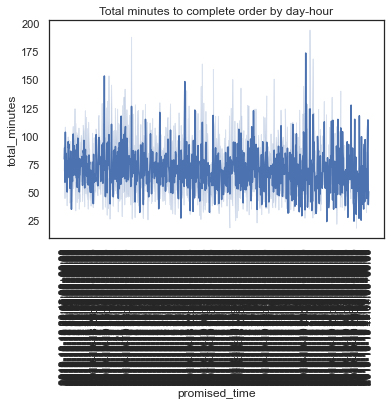

In [5]:
print(model_data.sort_values(by='promised_time')['total_minutes'].describe())
sns.lineplot(data=model_data, x="promised_time", y="total_minutes")
plt.xticks(rotation=90)
plt.title('Total minutes to complete order by day-hour')
plt.show()

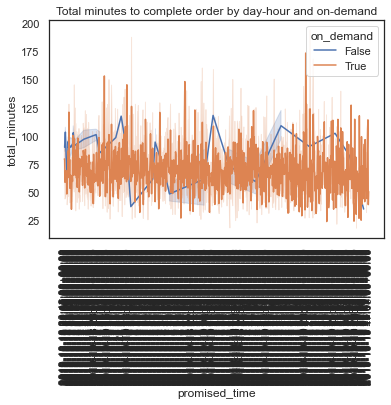

In [6]:
sns.lineplot(data=model_data,  x="promised_time", y="total_minutes",hue="on_demand")
plt.xticks(rotation=90)
plt.title('Total minutes to complete order by day-hour and on-demand')
plt.show()

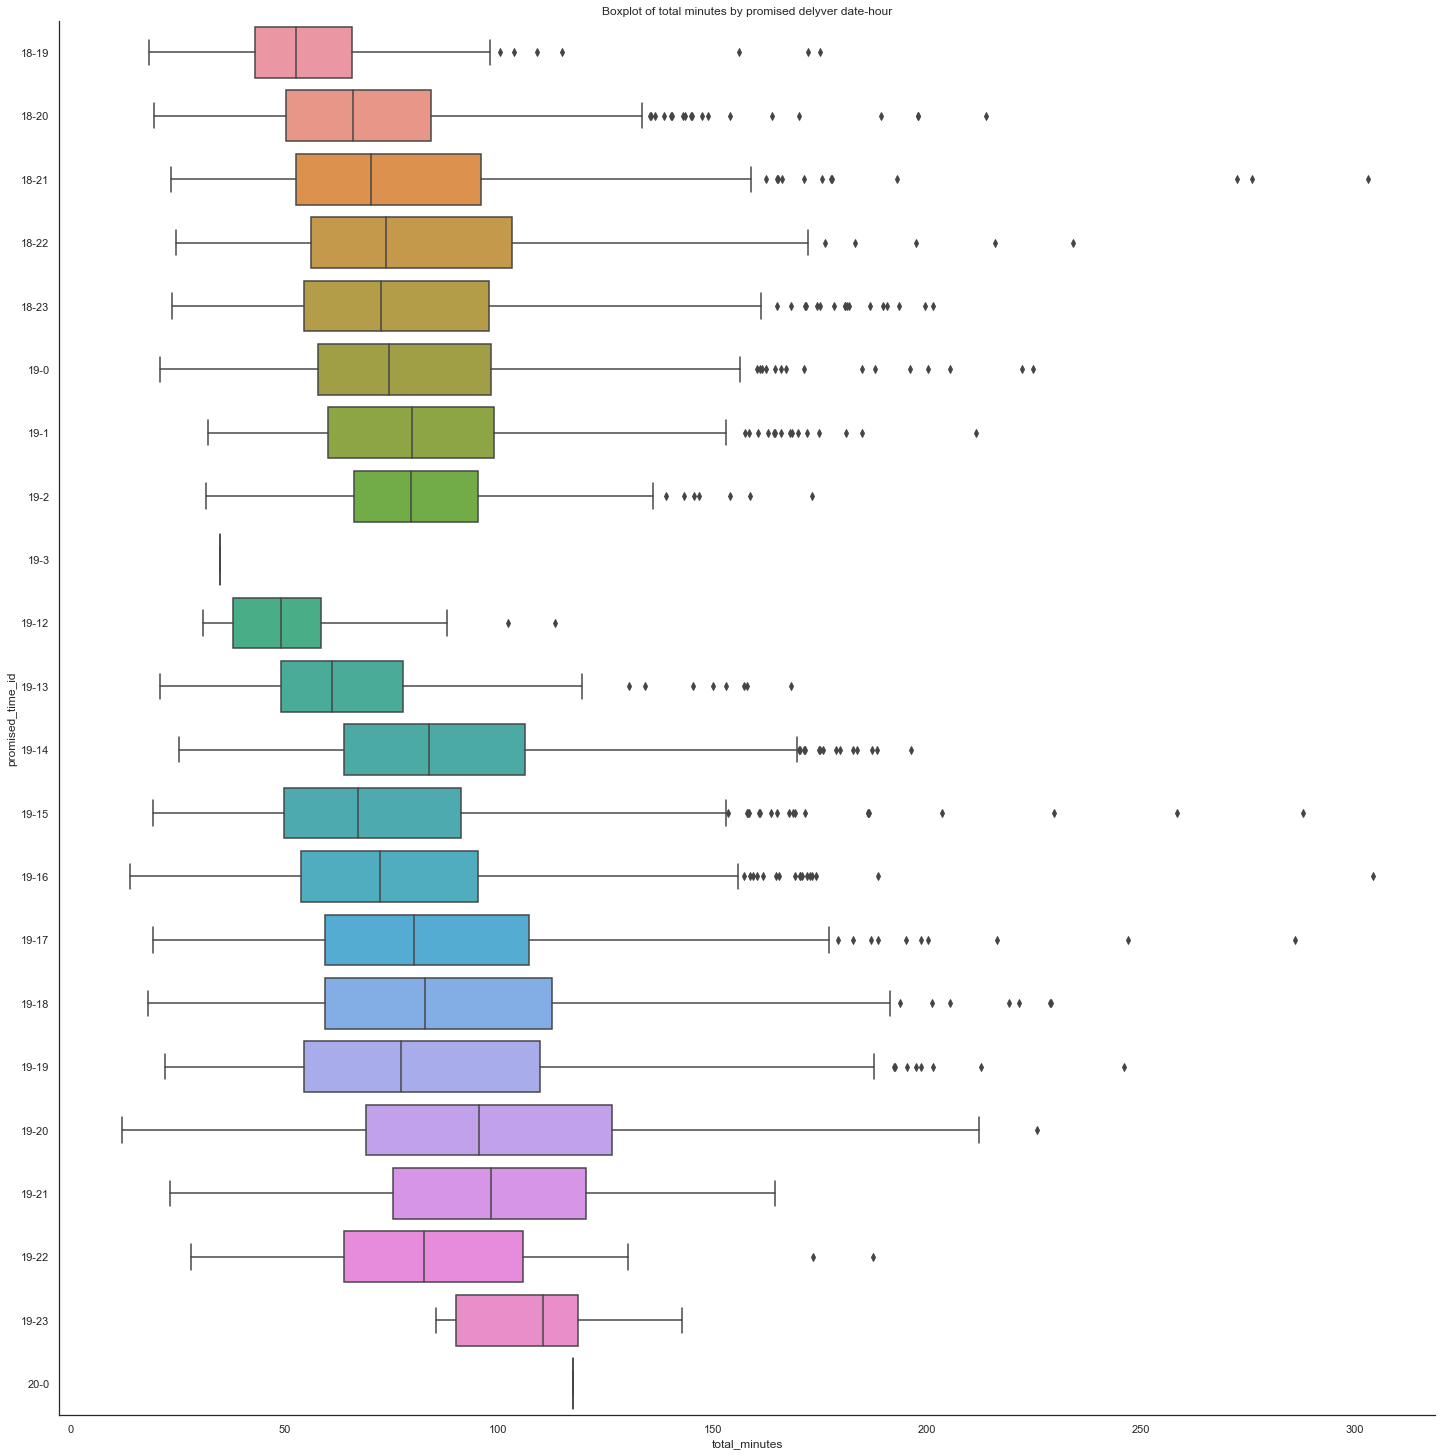

In [7]:
sns.catplot(x="total_minutes", y="promised_time_id",data=model_data,
            height=20,kind="box", order = model_data.sort_values(by='promised_time').promised_time_id.unique())
plt.title('Boxplot of total minutes by promised delyver date-hour')
plt.show();

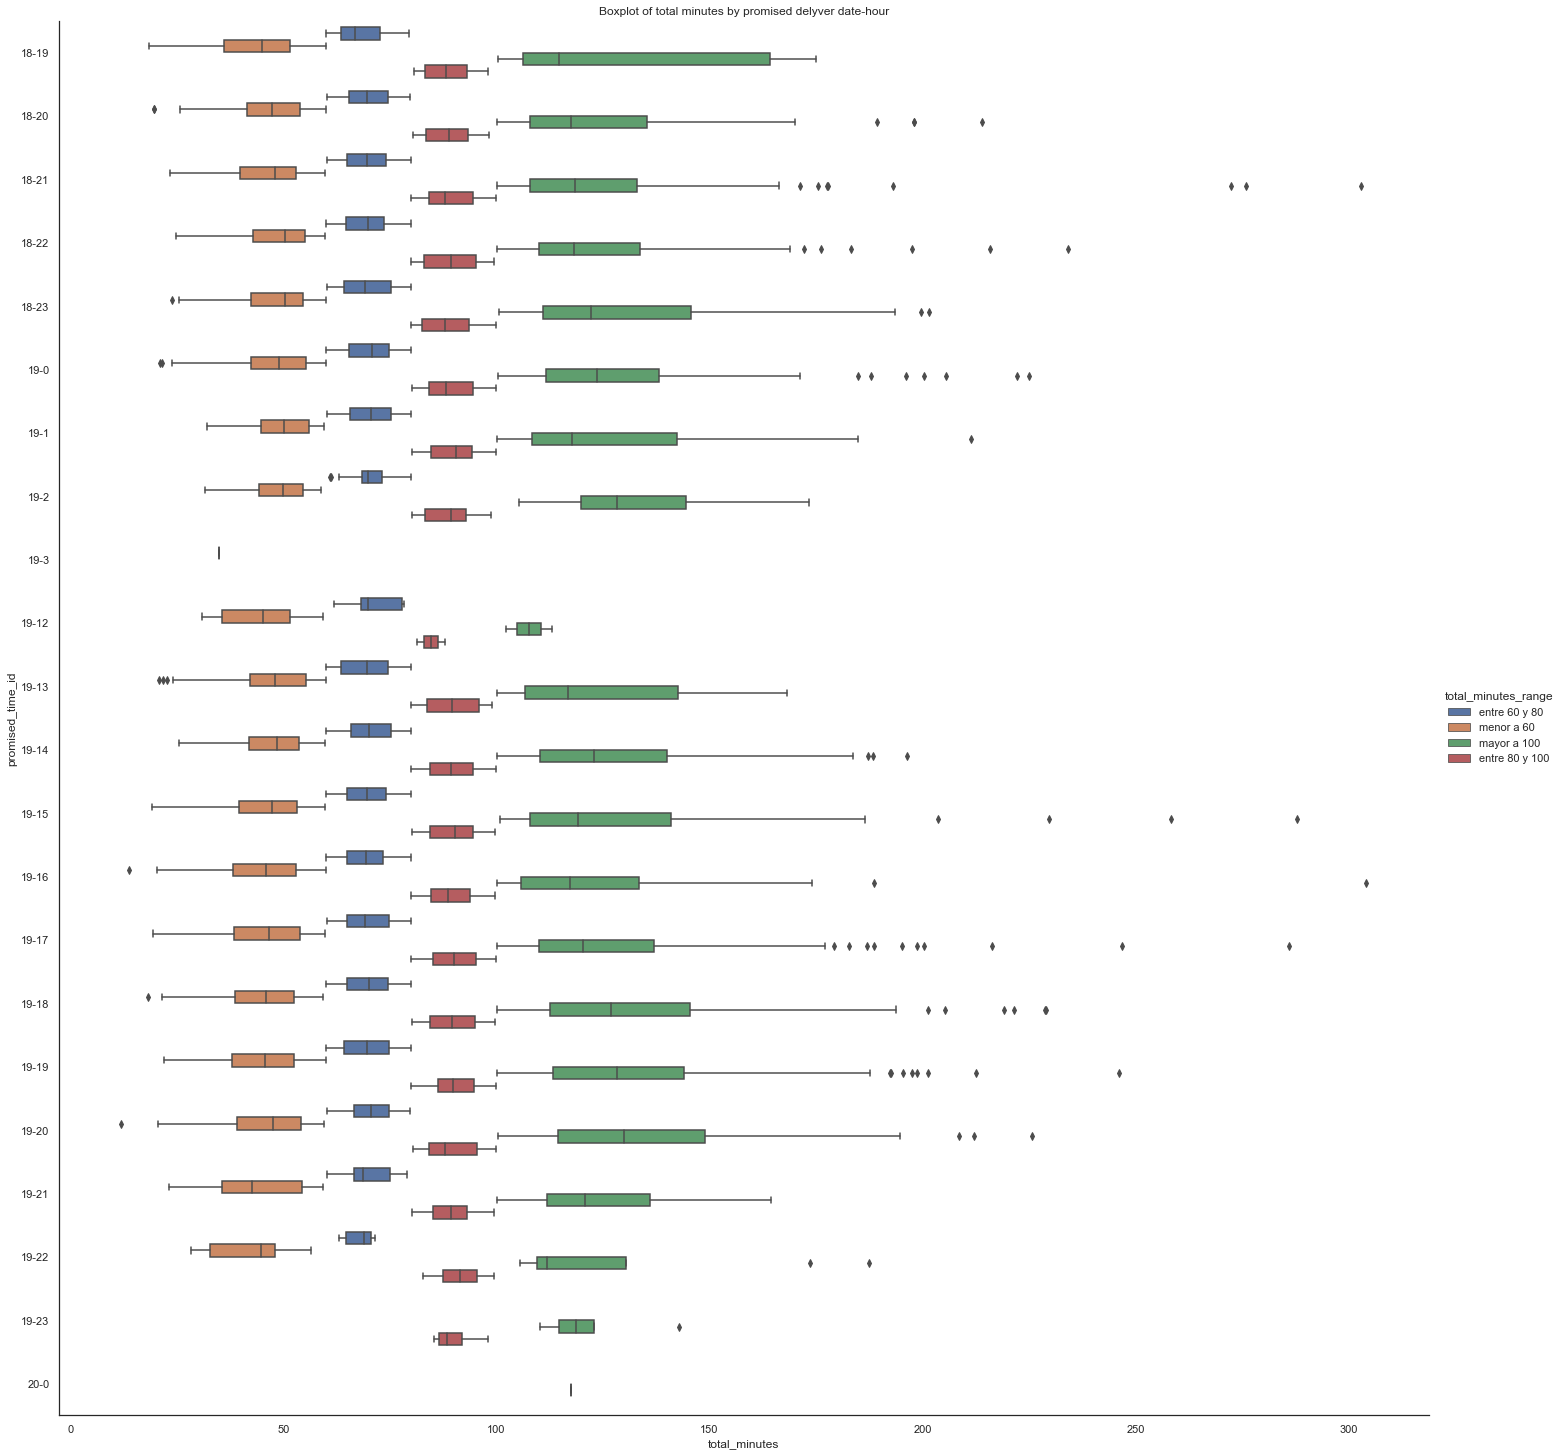

In [8]:
sns.catplot(x="total_minutes", y="promised_time_id",hue='total_minutes_range',data=model_data,
            height=20,kind="box", order = model_data.sort_values(by='promised_time').promised_time_id.unique())
plt.title('Boxplot of total minutes by promised delyver date-hour')
plt.show();

#### **Respondiendo a las preguntas iniciales** 

* **Which is the size of the sample?**

Se recolectaron 10.000 órdenes que fueron recolectadas por 2864 shoppers en 476 tiendas en 44 comunas de Chile (mayoritariamente RM). De las 10k, solo 8.000 tienen el tiempo total estimado por Cornershop y las otras 2.000 son órdenes sobre las cuales debemos hacer la predicción. Es por ello que usaremos separaremos la muestra en 2 dataset, los 8.000 datos con el nombre model_data y los otros 2.000 con el nombre results.


* **On what days and hours is the sample taken?**

Está tomada entre las 19pm del 18-10-2019 hasta las 00:00 del 19-10-2019 

* **¿Cuál es la magnitud de la cantidad de productos a entregar por hora?**

En las horas de baja demanda, la cantidad de productos por hora osciló entre 1 y 281 pedidos a entregar, mientras que en los peak de demanda osciló entre 498 hasta 958 pedidos a entregar por hora. Las horas de baja demanda fueron

* **On what days and hours do the peak applications occur?**

El peak del 18-10-2019 comienza a las 20pm y se extiende hasta las 00:00 del mismo día. El peak del 19-10-2019 se extiende entre las 14pm y las 20pm del mismo día

* **In what days and hours are the peak delays in completing the order?**

los peak de demora se situán principalmente en las horas posteriores a los peaks de entrega. La hipótesis es que esto se debe a un efecto de acumulación de órdenes de las horas previas que termina impacto negativamente en las horas inmediatamente posteriores

## Shoppers

### Preguntas para el análisis de los shopper

* El tiempo que demora una órden en llegar, ¿varia según las características del shoper?

* ¿Podemos agrupar a los shopper por sus características?

* En caso de que si se haya podido agrupar a los shoper por sus características: ¿hay diferencias significativas en el tiempo para completar el pedido entre las agrupaciones?

### **Evidencia**

count    2763.000000
mean        0.861082
std         0.031038
min         0.737300
25%         0.842900
50%         0.863900
75%         0.881950
max         0.971000
Name: found_rate, dtype: float64


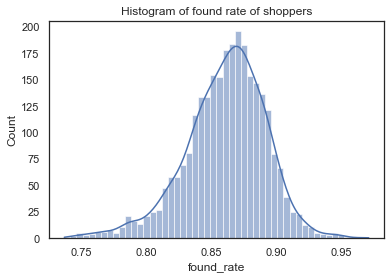

In [9]:
print(shoppers.found_rate.describe())
sns.histplot(data=shoppers, x="found_rate", kde=True, bins=50)
plt.title('Histogram of found rate of shoppers')
plt.show();

                      count      mean       std     min      25%     50%  \
total_minutes_range                                                        
entre 60 y 80        1951.0  0.864230  0.030278  0.7429  0.84735  0.8679   
entre 80 y 100       1483.0  0.863407  0.028960  0.7373  0.84735  0.8662   
mayor a 100          1973.0  0.858812  0.029856  0.7500  0.84090  0.8608   
menor a 60           2424.0  0.866352  0.029770  0.7429  0.84960  0.8696   

                         75%     max  
total_minutes_range                   
entre 60 y 80        0.88485  0.9647  
entre 80 y 100       0.88305  0.9453  
mayor a 100          0.87860  0.9710  
menor a 60           0.88620  0.9647  


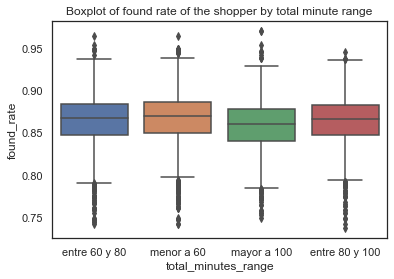

In [10]:
print(model_data.groupby('total_minutes_range')['found_rate'].describe())
sns.boxplot(x="total_minutes_range", y="found_rate",data=model_data)
plt.title('Boxplot of found rate of the shopper by total minute range');

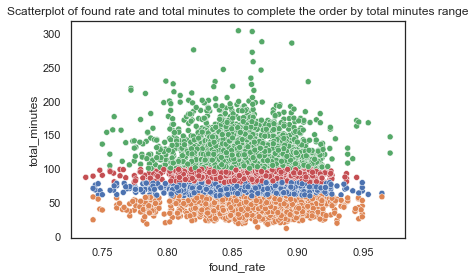

In [11]:
sns.scatterplot(data=model_data, y="total_minutes", x="found_rate", hue='total_minutes_range' , legend=False)
plt.title('Scatterplot of found rate and total minutes to complete the order by total minutes range')
plt.show();

count    8000.000000
mean        1.690111
std         0.630485
min         0.650000
25%         1.260000
50%         1.520000
75%         2.000000
max         7.040000
Name: picking_speed, dtype: float64


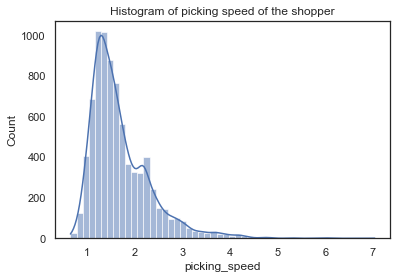

In [12]:
print(model_data.picking_speed.describe())
sns.histplot(data=model_data, x="picking_speed", kde=True, bins=50)
plt.title('Histogram of picking speed of the shopper');

                      count      mean       std   min   25%   50%    75%   max
total_minutes_range                                                           
entre 60 y 80        1994.0  1.656023  0.620995  0.73  1.25  1.50  1.900  5.98
entre 80 y 100       1503.0  1.654997  0.606296  0.73  1.26  1.50  1.880  7.04
mayor a 100          2019.0  1.767127  0.645457  0.73  1.31  1.58  2.095  6.11
menor a 60           2484.0  1.676123  0.635135  0.65  1.23  1.50  2.050  5.98


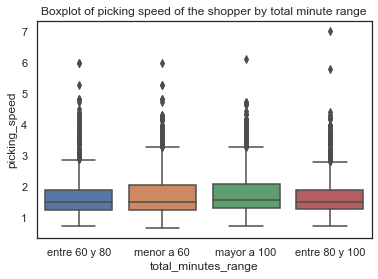

In [13]:
print(model_data.groupby('total_minutes_range')['picking_speed'].describe())
sns.boxplot(x="total_minutes_range", y="picking_speed",data=model_data)
plt.title('Boxplot of picking speed of the shopper by total minute range');

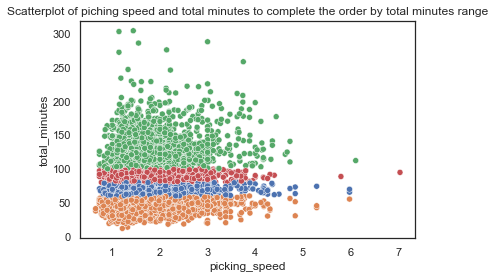

In [14]:
sns.scatterplot(data=model_data, y="total_minutes", x="picking_speed", hue='total_minutes_range',legend=False)
plt.title('Scatterplot of piching speed and total minutes to complete the order by total minutes range')
plt.show();

count    2780.000000
mean        4.848428
std         0.133011
min         3.880000
25%         4.800000
50%         4.880000
75%         4.960000
max         5.000000
Name: rating, dtype: float64


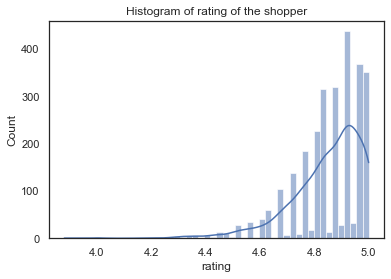

In [15]:
print(shoppers.rating.describe())
sns.histplot(data=shoppers, x="rating", kde=True, bins=50)
plt.title('Histogram of rating of the shopper');

                      count      mean       std   min   25%   50%   75%  max
total_minutes_range                                                         
entre 60 y 80        1961.0  4.852902  0.126724  3.88  4.80  4.88  4.96  5.0
entre 80 y 100       1482.0  4.848509  0.131998  4.00  4.80  4.88  4.96  5.0
mayor a 100          1980.0  4.850197  0.129326  4.00  4.76  4.88  4.96  5.0
menor a 60           2439.0  4.850795  0.123781  3.88  4.80  4.88  4.94  5.0


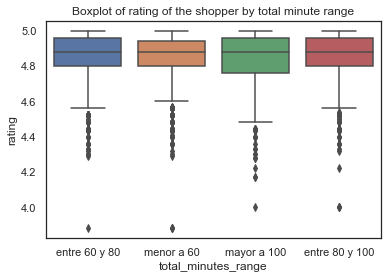

In [16]:
print(model_data.groupby('total_minutes_range')['rating'].describe())
sns.boxplot(x="total_minutes_range", y="rating",data=model_data)
plt.title('Boxplot of rating of the shopper by total minute range');

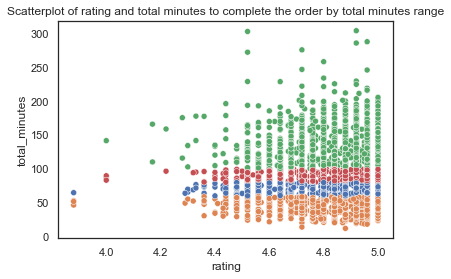

In [17]:
sns.scatterplot(data=model_data, y="total_minutes", x="rating", hue='total_minutes_range',legend=False)
plt.title('Scatterplot of rating and total minutes to complete the order by total minutes range')
plt.show();

count    2837.000000
mean        0.908276
std         0.107911
min         0.240000
25%         0.880000
50%         0.944444
75%         1.000000
max         1.000000
Name: accepted_rate, dtype: float64


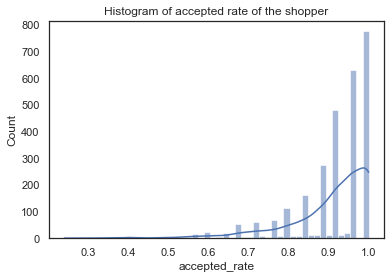

In [18]:
print(shoppers.accepted_rate.describe())
sns.histplot(data=shoppers, x="accepted_rate", kde=True, bins=50)
plt.title('Histogram of accepted rate of the shopper');

                      count      mean       std       min   25%       50%  \
total_minutes_range                                                         
entre 60 y 80        1984.0  0.918178  0.095789  0.320000  0.88  0.960000   
entre 80 y 100       1497.0  0.922206  0.090652  0.280000  0.88  0.960000   
mayor a 100          2004.0  0.911947  0.102453  0.240000  0.88  0.941176   
menor a 60           2474.0  0.915563  0.099243  0.285714  0.88  0.960000   

                     75%  max  
total_minutes_range            
entre 60 y 80        1.0  1.0  
entre 80 y 100       1.0  1.0  
mayor a 100          1.0  1.0  
menor a 60           1.0  1.0  


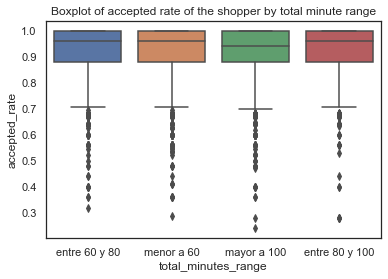

In [19]:
print(model_data.groupby('total_minutes_range')['accepted_rate'].describe())
sns.boxplot(x="total_minutes_range", y="accepted_rate",data=model_data)
plt.title('Boxplot of accepted rate of the shopper by total minute range');

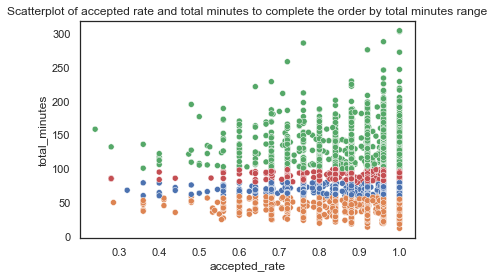

In [20]:
sns.scatterplot(data=model_data, y="total_minutes", x="accepted_rate", hue='total_minutes_range',legend=False)
plt.title('Scatterplot of accepted rate and total minutes to complete the order by total minutes range')
plt.show();

               count       mean        std        min        25%        50%  \
seniority                                                                     
ADVANCED      4904.0  80.928438  33.125084  11.969489  56.262478  75.247718   
BEGINNER      1207.0  81.781189  37.221665  18.192689  52.639455  74.872787   
INTERMEDIATE  1788.0  80.629333  36.740545  20.331018  53.469808  72.586850   
REVIEW         101.0  90.107319  41.328242  19.582987  58.809189  79.830846   

                     75%         max  
seniority                             
ADVANCED       99.480622  304.190303  
BEGINNER      104.100100  287.907109  
INTERMEDIATE  100.232315  285.964774  
REVIEW        117.737959  212.658895  


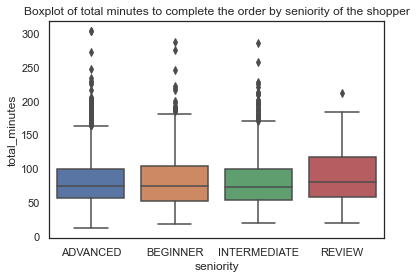

In [21]:
print(model_data.groupby('seniority')['total_minutes'].describe())
sns.boxplot(x='seniority', y="total_minutes",data=model_data)
plt.title('Boxplot of total minutes to complete the order by seniority of the shopper');

               total_minutes
found_rate         -0.109714
picking_speed       0.074073
accepted_rate      -0.011970
rating             -0.000127


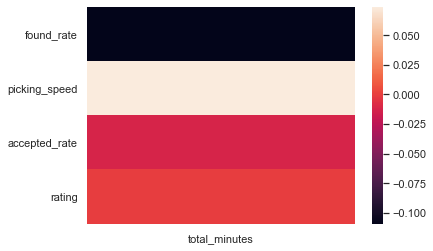

In [22]:
linear_corr = model_data.corr('spearman')[['total_minutes']].loc[['found_rate','picking_speed','accepted_rate','rating']]
print(linear_corr)
sns.heatmap(linear_corr);

### **Conclusiones:**

* El tiempo que demora una órden en llegar, ¿varia según las características del shoper?

No existe correlación lineal entre las variables que describen a los shopper y el tiempo total para completar el pedido, asi como tampoco con la cantidad de entregas que hicieron en el periodo analizado. 
Tampoco vemos variaciones en la dispersión de los valores del tiempo total de entrega según ratio con el que encuetra el producto, velocidad de recogida, ratio de aceptación y rating del shopper . La única relación que si se puede extraer es que los shopper en review demoran, en promedio, más que los novatos, intermedios y avanzados.

* ¿Podemos agrupar a los shopper por sus características?

* En caso de que si se haya podido agrupar a los shoper por sus características: ¿hay diferencias significativas en el tiempo para completar el pedido entre las agrupaciones?

-------------------------------------------------------------------------

## Store

Preguntas de investigación para entender la relación del tiempo en completar el pedido con las tiendas:

* ¿Cuántas son?
    
* ¿Dónde están localizadas?

* El tiempo que demora una órden en llegar, ¿varia según las características de la tienda?

### **Evidencia**

In [23]:
aux = get_measure_central_tendency(model_data,'order_id','store_district', 'total_minutes')
aux.describe()

,mean,std,median,quantity,coef_var_pearson,cumsum_quantity,cumsum_quantity_pp
count,34.000000,30.000000,34.000000,34.000000,30.000000,34.000000,34.000000
mean,83.942767,31.896239,79.389006,235.294118,0.373353,1103.117647,0.137890
std,18.663289,7.121205,17.621856,468.720795,0.071143,1816.563368,0.227070
min,39.979772,12.700488,39.979772,1.000000,0.174229,1.000000,0.000125
25%,73.197075,27.586538,67.652066,7.250000,0.338147,28.000000,0.003500
50%,83.856154,31.979787,79.915457,64.500000,0.374836,346.500000,0.043313
75%,95.886331,36.575105,91.071562,139.250000,0.404777,1208.750000,0.151094
max,117.387279,44.377747,115.421446,2142.000000,0.521101,8000.000000,1.000000


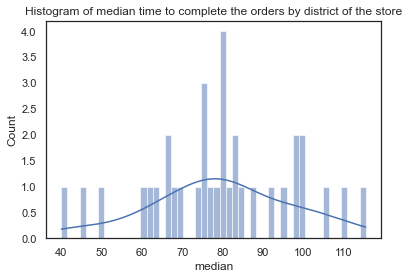

In [24]:
sns.histplot(data=aux, x="median", kde=True, bins=50)
plt.title('Histogram of median time to complete the orders by district of the store')
plt.show();

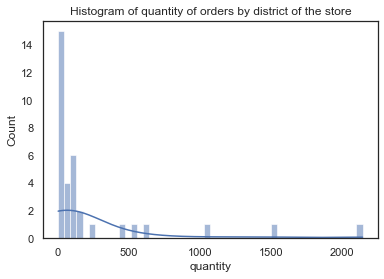

In [25]:
sns.histplot(data=aux, x="quantity", kde=True, bins=50)
plt.title('Histogram of quantity of orders by district of the store')
plt.show();

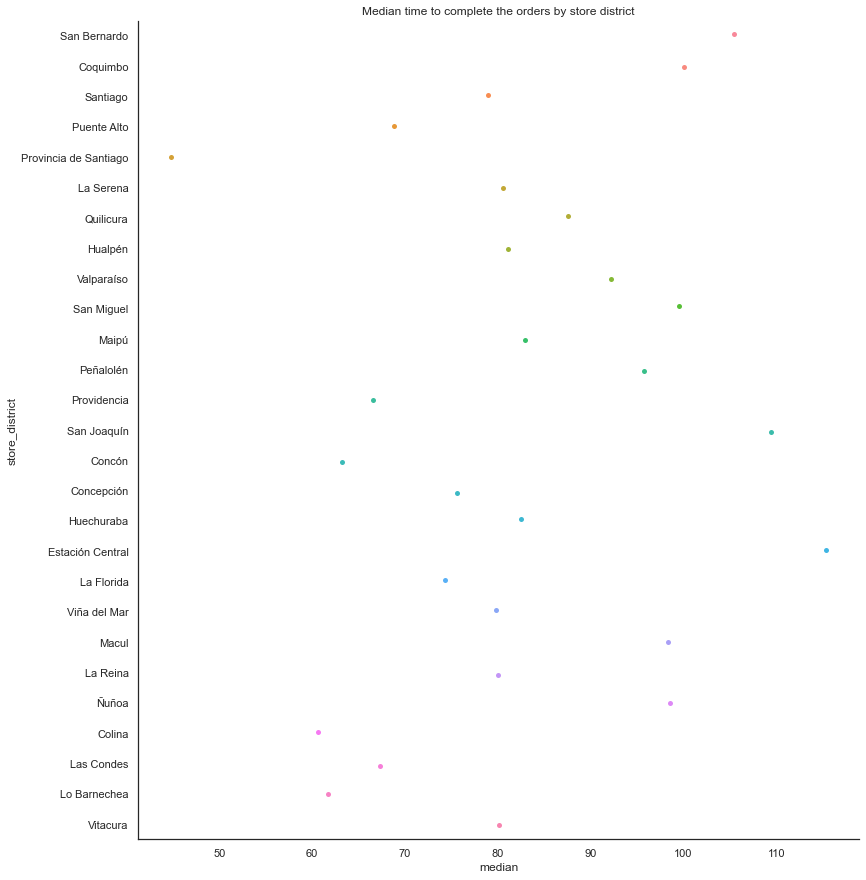

In [26]:
sns.catplot(x="median", y="store_district",orient="h", data=aux[aux.quantity>=5],aspect=1,height=12, legend=True)
plt.title('Median time to complete the orders by store district')
plt.show();

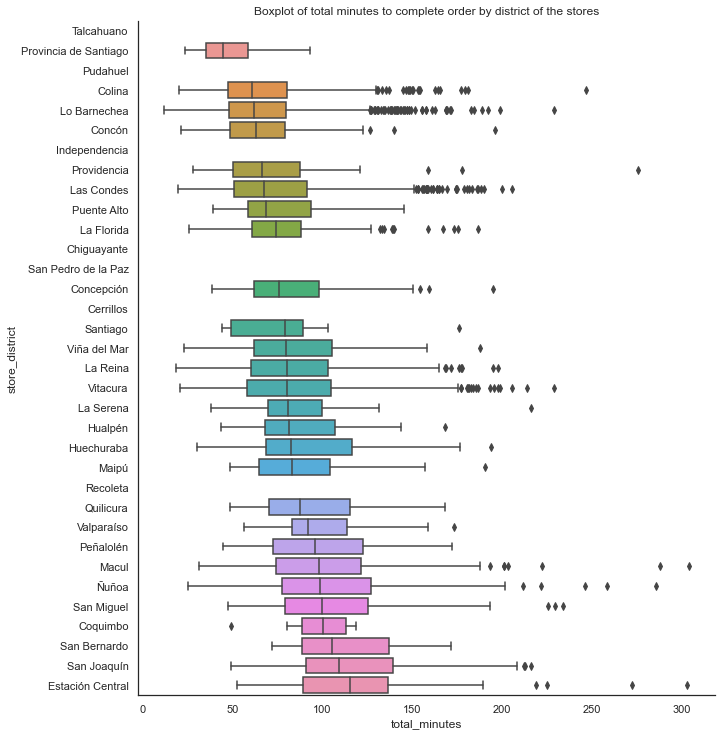

In [27]:
store_size_rep = list(aux[aux.quantity>=5].store_district)
aux2 = model_data.loc[model_data.store_district.apply(lambda x: True if x in store_size_rep else False)]
sns.catplot(x="total_minutes", y="store_district",data=aux2,
            height=10,kind="box", order= aux.sort_values(by='median').store_district.unique())
plt.title('Boxplot of total minutes to complete order by district of the stores')
plt.show();

                      count      mean       std       min       25%       50%  \
total_minutes_range                                                             
entre 60 y 80        1994.0  2.847165  1.830415  0.076566  1.499135  2.445005   
entre 80 y 100       1503.0  3.005694  1.850266  0.096322  1.722679  2.681910   
mayor a 100          2019.0  3.215323  1.979520  0.081133  1.921805  2.891738   
menor a 60           2484.0  2.574810  1.630224  0.077871  1.362334  2.244533   

                          75%        max  
total_minutes_range                       
entre 60 y 80        3.874442  16.498146  
entre 80 y 100       4.031319  16.388548  
mayor a 100          4.168596  16.631580  
menor a 60           3.501539  13.799989  


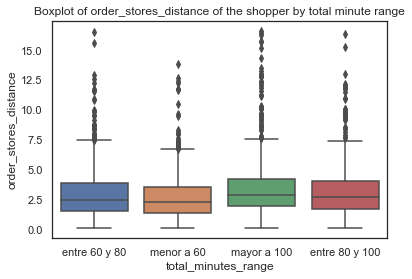

In [28]:
print(model_data.groupby('total_minutes_range')['order_stores_distance'].describe())
sns.boxplot(x="total_minutes_range", y='order_stores_distance',data=model_data)
plt.title('Boxplot of order_stores_distance of the shopper by total minute range');

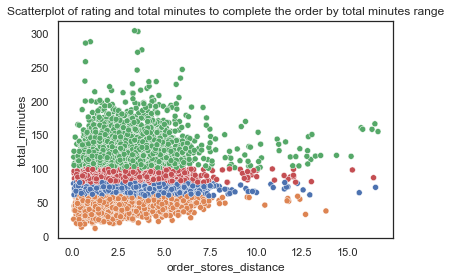

In [29]:
sns.scatterplot(data=model_data, y="total_minutes", x="order_stores_distance", hue='total_minutes_range',legend=False)
plt.title('Scatterplot of rating and total minutes to complete the order by total minutes range')
plt.show();

In [30]:
len(set(results.store_branch_id).difference(set(model_data.store_branch_id)))

NameError: name 'results' is not defined

### **Conclusiones:**

* ¿Cuántas son y dónde están localizadas?



* El tiempo que demora una órden en llegar, ¿varia según las características de la tienda?

## Relación entre órdenes y productos

Queremos entender: 

* ¿Cuál es la magnitud de la cantidad de productos por orden?


* ¿Qué tan variado es el mix de productos por órden? ¿hay un X% de productos que tienen una frecuencia solicitada significativamente mayor?


* De los productos que más piden, ¿cuál es el rango de la cantidad que solicitan de ellos? 

#### Evidencia

In [ ]:
# Loading Order Products dataset
order_products = pd.read_csv('interim/order_products.csv', sep=';')
print(order_products.shape)
get_na(order_products)

In [ ]:
# con esto calculo la cantidad de órdenes que tengo y cuántos productos me piden por orden
aux = order_products.groupby(['order_id'])['quantity'].sum().reset_index()
print(aux.shape)
aux.head(3)

In [ ]:
sns.histplot(data=aux, x="quantity", kde=True, binwidth=5)
plt.title('Histogram of quantity of orders');

In [ ]:
print(aux.quantity.describe())
ax = sns.boxplot(x = aux["quantity"])
plt.title('Boxplot of quantity of orders');

In [ ]:
# calculo el percentil de las órdenes que superan los 100 productos
print(np.percentile(aux.quantity, 90))

Podemos ver que de las 9978 órdenes que tenemos:

1.- Un 50% de las órdenes tiene entre 12 y 50 productos, solo un 25% superan esa cantidad.

2.- Un 25% tiene menos de 12 productos

3.- El 10% de órdenes con más productos tienen 80 productos o más

Esta información es relevante al momento de tomar decisiones, especialmente si encontramos relación entre la cantidad de productos y el tiempo en completar la orden, que es algo que esperamos que ocurra

In [ ]:
aux = get_measure_central_tendency(order_products,"order_id","product_id",'quantity')
print(aux.shape)
aux.sort_values(by='mean').tail(3)

In [ ]:
# acá vemos que en 5983 de los 15422 productos(39%) el promedio no es representativo, es por ello que usaremos la mediana como métrica
print(sum(aux.coef_var_pearson>0.3))
100 * sum(aux.coef_var_pearson>0.3) / aux.shape[0]

In [ ]:
sns.histplot(data=aux, x="median", kde=True, bins=100);
plt.title('Histogram of median to complete the orders');

In [ ]:
print(aux['median'].describe())
ax = sns.boxplot(x = aux["median"])
plt.title('Boxplot of median to complete the orders');

In [ ]:
print(aux.quantity.describe())
sns.histplot(data=aux, x="quantity", kde=True, bins=100)
plt.title('Histogram of quantity of products by orders');

In [ ]:
ax = sns.boxplot(x = aux["quantity"])
plt.title('Boxplot of quantity of products by orders');

In [ ]:
# calculo el valor asociado al percentil que entrego
print(np.percentile(aux.quantity,90))
# calculo el valor asociado al percentil que entrego
print(np.percentile(aux.quantity,97.8))

En los 15422 productos podemos observar que:

1.- El 52% ha sido solicitado apenas 2 veces o menos (0.02% del total de órdenes)

2.- El 90% ha sido solicitado 25 veces o menos (0.25% del total de órdenes)

3.- El 2.2% de los productos es el que ha sido solicitado más de 99 veces (osea, más del 1% de las órdenes)

Esto plantea una complejidad importante pues la variabilidad de los productos es extremadamente alta y probablemente no nos ayude mucho incluirla como variable a menos que podamos hacer agrupaciones por categorías y/o familias, lo que no se puede en esta ocasión ya que no tenemos el diccionario con las descripciones.

Inicialmente, dejaremos esta variable como una candidata fuerte a ser eliminada pues es muy probable que introduzca más ruido que capacidad predictiva.

In [ ]:
aux = get_get_measure_central_tendency_2(order_products,'order_id','product_id','buy_unit','quantity')
print(aux.shape)
aux.head(3)

In [ ]:
print(aux.groupby('buy_unit')['quantity'].describe())
sns.boxplot(x="buy_unit", y="quantity",data=aux)
plt.title('Boxplot of quantity of products by orders and units');

In [ ]:
print(aux.groupby('buy_unit')['median'].describe())
sns.boxplot(x="buy_unit", y="median",data=aux)
plt.title('Boxplot of median to complete the order by units');

In [ ]:
print(aux.groupby('buy_unit')['mean'].describe())
sns.boxplot(x="buy_unit", y="mean",data=aux)
plt.title('Boxplot of mean to complete the order by units');

Al separarar por los productos que se miden en unidades y kgs podemos concluir que:

1.- En promedio,para el 75% de los productos solicitados,la cantidad que piden por producto va entre 1 y 1.75 unidades o 0.1 a 1.5kg

2.- Es importante notar que la cantidad de productos que se miden en kgs es solo un 3.7% de lo solicitado

3.- Será bueno entender si el hecho de que el peso total solicitado en unidades o kg genera algún cambio significativo en los tiempos para completar la orden

### Respondiendo a nuestras preguntas iniciales

**1.- ¿Cuál es la magnitud de la cantidad de productos por orden?**

La gran mayoría (75%) tiene menos de 50 productos por orden y solo un 10% de las órdenes tiene 80 productos o más

**2.- ¿Qué tan variado es el mix de productos por órden? ¿hay un X% de productos que tienen una frecuencia solicitada significativamente mayor?**

Muy variado, apenas un 2.2% de los productos ha sido solicitado en más del 1% de las pedidos. Por otro lado solo un 3.7% de los productos solicitados se miden en kgs , mientras que el resto en unidades y en promedio,para el 75% de los productos solicitados,la cantidad que piden por producto varía entre 1 y 1.75 unidades o 0.1 a 1.5kg.

**3.- De los productos que más piden, ¿cuál es el rango de la cantidad que solicitan de ellos?**

Esto pasa a ser irrelevante dado que son muy pocos productos los que se solicitan frecuentemente y tendrán un impacto muy acotado en mi capacidad de predecir


-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Orders

**Con respecto a las órdenes las preguntas de investigación son** 

* ¿Cuánto es el tiempo que normalmente demora una orden en llegar?

* ¿Cuánto es el tiempo que normalmente demora una orden en llegar según si se prometió para el plazo X o no? ¿Hay variaciones entre las dos categorías? 

* El tiempo que demora una órden en llegar, ¿varia por comuna?

* ¿Hay comunas asignadas a los datos a predecir de las que no tengamos registros históricos?

* El tiempo que demora una órden en llegar, ¿varia por shoper?

* ¿Hay shoppers que asignados a los datos a predecir de los que no tengamos registros históricos de su desempeño?

* El tiempo que demora una órden en llegar, ¿varia por tienda?

* ¿Hay tiendas asignadas en los datos a predecir de los que no tengamos registros históricos previamente?

**Sobre el tiempo para completar la orden**

* ¿Cuánto es el tiempo que normalmente demora una orden en llegar?

### Evidence

In [ ]:
sns.histplot(data= model_data, x="total_minutes", kde=True, binwidth=2)
plt.title('Histogram of total minutes complete the order by units');

In [ ]:
print(model_data.total_minutes.describe())
sns.boxplot(x = model_data["total_minutes"])
plt.title('Boxplot of total minutes complete the order by units');

In [ ]:
# calculo el valor asociado al percentil que entrego
print(np.percentile(model_data.total_minutes,31))
# calculo el valor asociado al percentil que entrego
print(np.percentile(model_data.total_minutes,66))
# calculo el valor asociado al percentil que entrego
print(np.percentile(model_data.total_minutes,86.6))
# calculo el valor asociado al percentil que entrego
print(np.percentile(model_data.total_minutes,95))

#### Análsis por promesa de tiempo de llegada

* ¿Cuánto es el tiempo que normalmente demora una orden en llegar según si se prometió para el plazo X o no? ¿Hay variaciones entre las dos categorías?

In [ ]:
sns.histplot(data=model_data, x="total_minutes", hue="sla",multiple="stack")
plt.title('Histogram (stacked) of total minutes by promised delyver in less than X time or not')
plt.show();

In [ ]:
sns.histplot(data=model_data, x="total_minutes", hue="sla",element="step",stat="density", common_norm=False)
plt.title('Histogram of total minutes by promised delyver in less than X time or not')
plt.show();

In [ ]:
model_data.groupby(['sla']).total_minutes.describe()

In [ ]:
ax = sns.boxplot(x="total_minutes", y="sla", data=model_data)
plt.title('Boxplot of total minutes by promised delyver in less than X time or not')
plt.show();

#### **Análisis de órdenes por comuna**

* El tiempo que demora una órden en llegar, ¿varia por comuna? ¿es una variable candidata a ser utilizada como variable explicativa / predictiva?
* ¿Hay comunas asignadas a los datos a predecir de las que no tengamos registros históricos?

In [ ]:
aux = get_measure_central_tendency(model_data,'order_id','district','total_minutes')
aux

In [ ]:
# acá vemos que en 31 de las 45 comunas (69%) el promedio no es representativo, es por ello que usaremos la mediana como métrica
print(sum(aux.coef_var_pearson>0.3))
100 * sum(aux.coef_var_pearson>0.3) / aux.shape[0]

In [ ]:
sns.histplot(data=aux, x="median", kde=True, bins=50)
plt.title('Histogram of median time to complete the orders by district')
plt.show();

In [ ]:
sns.catplot(x="median", y="district",orient="h", hue='quantity', data=aux,aspect=1,height=12)
plt.title('Median time to complete the orders by district')
plt.show();

In [ ]:
print(aux['median'].describe())
ax = sns.boxplot(x = aux["median"])
plt.title('Boxplot of median time to complete the orders by district')
plt.show();

In [ ]:
print(aux[aux.quantity>=30]['median'].describe())
ax = sns.boxplot(x = aux[aux.quantity>=30]["median"])
plt.title('Boxplot of median time to complete the orders by district')
plt.show();

In [ ]:
set(results.district).difference(set(model_data.district))

In [ ]:
set(model_data.district).difference(set(results.district))

In [ ]:
district_size_rep = list(aux[aux.quantity>=20].district)
aux2 = model_data.loc[model_data.district.apply(lambda x: True if x in district_size_rep else False)]
sns.catplot(x="total_minutes", y="district",data=aux2,
            height=10,kind="box",order=list(aux[aux.quantity>=20].sort_values(by='median', ascending=False).district))
plt.title('Boxplot of total minutes by promised delyver in less than X time or not')
plt.show();

In [ ]:
district_size_rep = list(aux[aux.quantity>=20].district)
aux2 = model_data.loc[model_data.district.apply(lambda x: True if x in district_size_rep else False)]
sns.catplot(x="total_minutes", y="district",hue='total_minutes_range',data=aux2,
            height=20,kind="box",order=list(aux[aux.quantity>=20].sort_values(by='median', ascending=False).district))
plt.title('Boxplot of total minutes by promised delyver in less than X time or not')
plt.show();

In [ ]:
district_size_rep = list(aux[aux.quantity>=20].district)
aux2 = model_data.loc[model_data.district.apply(lambda x: True if x in district_size_rep else False)]
sns.catplot(x="total_minutes", y="promised_time_id",data=aux2,
            height=10,kind="box", order= aux2.sort_values(by='promised_time').promised_time_id.unique())
plt.title('Boxplot of total minutes by promised delyver in less than X time or not')
plt.show();

In [ ]:
district_size_rep = list(aux[aux.quantity>=20].district)
aux2 = model_data.loc[model_data.district.apply(lambda x: True if x in district_size_rep else False)]
sns.catplot(x="total_minutes", y="promised_time_id",hue='total_minutes_range',data=aux2,
            height=20,kind="box", order = aux2.sort_values(by='promised_time').promised_time_id.unique())
plt.title('Boxplot of total minutes by promised delyver in less than X time or not')
plt.show();

#### Análisis de órdenes por shopper

* El tiempo que demora una órden en llegar, ¿varia por shoper?

* ¿Hay shoppers que asignados a los datos a predecir de los que no tengamos registros históricos de su desempeño?

In [ ]:
aux = get_measure_central_tendency(model_data,'order_id','shopper_id','total_minutes')
aux.sort_values(by='quantity')

In [ ]:
print(aux['quantity'].describe())
ax = sns.boxplot(x = aux["quantity"])
plt.title('Boxplot of quantity orders by shopper')
plt.show();

In [ ]:
print(aux[aux.quantity>=3]['median'].describe())
ax = sns.boxplot(x = aux["median"])
plt.title('Boxplot of median time to complete the orders by shopper')
plt.show();

In [ ]:
shopper_size_rep = list(aux[aux.quantity>=8].shopper_id)
sns.catplot(x="median", y="shopper_id",orient="h", hue='quantity', 
            data=aux.loc[aux.shopper_id.apply(lambda x: True if x in shopper_size_rep else False)],aspect=1,height=12)
plt.title('Median time to complete the orders by shopper')
plt.show();

In [ ]:
aux2 = model_data.loc[model_data.shopper_id.apply(lambda x: True if x in shopper_size_rep else False)]
sns.catplot(x="total_minutes", y="shopper_id",data=aux2,
            height=10,kind="box",order=list(aux[aux.quantity>=8].sort_values(by='median', ascending=False).shopper_id))
plt.title('Boxplot of total minutes to complete order by shoppers with more than 7 observations')
plt.show();

In [ ]:
len(set(results.shopper_id).difference(set(model_data.shopper_id)))

#### **Evidencia**

In [ ]:
aux = get_measure_central_tendency(model_data,'order_id','shopper_id', 'total_minutes')
aux.describe()

In [ ]:
sns.histplot(data=aux, x="quantity", kde=True, bins=50);

In [ ]:
# acá vemos que en 1035 de los 2735 shoppers (37%) el promedio no es representativo, es por ello que usaremos la mediana como métrica
print(sum(aux.coef_var_pearson>0.3))
100 * sum(aux.coef_var_pearson>0.3) / aux.shape[0]

In [ ]:
sns.histplot(data=aux, x="median", kde=True, bins=50);

In [ ]:
print(aux['median'].describe())
ax = sns.boxplot(x = aux["median"])

In [ ]:
print(aux[aux.quantity>=4]['median'].describe())
ax = sns.boxplot(x = aux[aux.quantity>=4]["median"])

In [ ]:
# calculo el valor asociado al percentil que entrego
print(np.percentile(aux.quantity,27))
# calculo el valor asociado al percentil que entrego
print(np.percentile(aux.quantity,49))
# calculo el valor asociado al percentil que entrego
print(np.percentile(aux.quantity,68))

In [ ]:
print('la cantidad de shoppers que están en los datos a predecir y no en los de entrenamiento son:' + str(len(set(results.shopper_id).difference(set(model_data.shopper_id)))))

print('la cantidad de shoppers que están en los datos de entrenamiento y no en los datos a predecir son:' + str(len(set(model_data.shopper_id).difference(set(results.shopper_id)))))

#### **Conclusiones:**

* Un 27% de los shopper solo tiene una orden realizada, un 22% solo 2 y un 19% solo 3, lo que significa que un 68% tiene menos de 3 datos históricos en esta muestra. Esto se explica porque la muestra está concentrada en solo 2 días (18-09-2019 y 19-09-2019)

* Efectivamente vemos diferencias en los tiempos en completar la orden por shopper, sin embargo considerando lo que se explicó anteriormente, no podemos decir con certeza que esto se deba a diferencias atribuibles a la persona en particular usando el shopper_id

* Adicionalmente hay 129 shoppers en la muestra que debemos predecir que no están en los datos de entrenamiento

* Como alternativa, y dado que en la tabla shoppers tenemos datos de su comportamiento histórico, evaluaremos la posibilidad de usar esos atributos como variables explicativas para predecir el tiempo para terminar la orden

-------------------------------------------------------------------------

#### Preguntas sobre las tiendas

* El tiempo que demora una órden en llegar, ¿varia por tienda? 

* ¿Hay tiendas asignadas en los datos a predecir de los que no tengamos registros históricos previamente?

In [ ]:
aux = get_measure_central_tendency(model_data,'order_id','store_branch_id', 'total_minutes')
aux.describe()

In [ ]:
sns.histplot(data=aux, x="quantity", kde=True, bins=50);

In [ ]:
# calculo el valor asociado al percentil que entrego
print(np.percentile(aux.quantity,41))
# calculo el valor asociado al percentil que entrego
print(np.percentile(aux.quantity,57))
# calculo el valor asociado al percentil que entrego
print(np.percentile(aux.quantity,67))

In [ ]:
sns.histplot(data=aux, x="median", kde=True, bins=50);

In [ ]:
print(aux['median'].describe())
ax = sns.boxplot(x = aux["median"])

In [ ]:
store_size_rep = list(aux[aux.quantity>=10].store_branch_id)
sns.catplot(x="median", y="store_branch_id",orient="h", 
            data=aux.loc[aux.store_branch_id.apply(lambda x: True if x in store_size_rep else False)],aspect=1,height=12)
plt.title('Median time to complete the orders by store')
plt.show();

In [ ]:
aux2 = model_data.loc[model_data.store_branch_id.apply(lambda x: True if x in store_size_rep else False)]
sns.catplot(x="total_minutes", y="store_branch_id",data=aux2,
            height=10,kind="box",order=list(aux[aux.quantity>=10].sort_values(by='median', ascending=False).store_branch_id))
plt.title('Boxplot of total minutes to complete order on stores with more than 10 observations')
plt.show();

In [ ]:
print('la cantidad de tiendas que están en los datos a predecir y no en los de entrenamiento son:' + str(len(set(results.store_branch_id).difference(set(model_data.store_branch_id)))))

print('la cantidad de tiendas que están en los datos de entrenamiento y no en los datos a predecir son:' + str(len(set(model_data.store_branch_id).difference(set(results.store_branch_id)))))

### **Respondiendo a las preguntas:**

* **¿Cuánto es el tiempo que normalmente demora una orden en llegar?**

Solo el 31% de las órdenes tarda menos de 1 hora (60 minutos), Mientras que el 66% de las órdenes tarda menos de 90 minutos y el 86% de las órdenes se demora menos de 120 minutos. Es importante notar que hay un 5% de órdenes que tardan más de 150 minutos (2.5 horas) y que son los outier que vemos en el boxplot que se muestra en la evidencia

* **¿Cuánto es el tiempo que normalmente demora una orden en llegar según si fue on demand o no? ¿Hay variaciones entre las dos categorías?** 


* **El tiempo que demora una órden en llegar, ¿varia por comuna?**

Hay comunas de las cuales hay muy pocos datos para usar su información, pues tienen muy poco historial con órdenes (solo 20 de las 44 comunas (45%) tiene más de 30 datos) Al filtrar por dichas comunas, podemos obervar que hay variaciones importantes entre comunas y que además existen algunas comunas donde la dispersión es significativamente mayor al resto (Providencia, Santiago, San Miguel, etc). **También es necesario notar que las 3 comunas en donde los tiempos en completar el pedido son más altas son comunas que se vieron fuertemente afectadas en el tráfico por las protestas los días que se recogió la muestra. Aún así, no es posible asegurar que esta sea la causa de las variaciones, pues hay comunas como Puente Alto que están dentro de las más bajas y también tuvo fuertes manifestaciones**

* **¿Hay comunas asignadas a los datos a predecir de las que no tengamos registros históricos?**

Si, San Ramón. En un inicio, no estaríamos considerando la variable comuna como una variable explicativa / predictiva pues nos enfrentaríamos al problema de poca representitividad del historial y/o que derechamente puedan llegar datos sin historial como nos pasa en el data de resultados con San Ramón. **Es por ello que vamos a explorar la distancia entre dónde debe llegar la orden y la tienda como variable explicativa**

* **El tiempo que demora una órden en llegar, ¿varia por shoper?**

Efectivamente, el tiempo medio que demora una orden en llegar varia entre los shopper, tal y como se puede observar en el boxplot de shoppers con más de 3 órdenes completadas. Podemos ver que incluso hay shoppers con tiempos promedio sobre 150 minutos para completar la orden. 

Luego en el boxplot con los 64 shoppers que tienen más de 8 órdenes completadas podemos observar grandes diferencias en los tiempos en completar la orden y diferencias aún más grandes en la dispersión de esos tiempos entre los shopper. Esto sugiere dos cosas:

1.- Es posible que los tiempos de los shopper que tienen alta varaibilidad sean causados porque los pedidos que recibió en este inervalo de tiempo tuvieron una naturaleza (composición) y contexto muy distinto

2.- El shopper no es constante en su rapidez para terminar el trabajo (algo que se debería reflejar en los atributos que lo caracterizan)

3.- Ambas

* **¿Hay shoppers que asignados a los datos a predecir de los que no tengamos registros históricos de su desempeño?**

Si, hay 129 shoppers que están en los datos a predecir pero no en el conjunto de entrenamiento. En un inicio, no estaríamos considerando la variable shopper como una variable explicativa / predictiva por las mismas razones que no usaremos el district, sin embargo **si exploraremos utilizar las variables que caracterizan a los shopper sin individualizarlos**

* **El tiempo que demora una órden en llegar, ¿varia por tienda?**

Efectivamente vemos diferencias en los tiempos en completar la orden por tienda y en la dispersión de dichos tiempos, como podemos observar en el boxplot donde filtramos solo para aquellas tiendas con más de 10 observaciones.
Es importante notar que un 41% de las tiendas solo tiene una orden realizada, un 57% solo 2 y un 67% solo 3, lo que significa que un 67% tiene menos de 3 datos históricos en esta muestra. Esto se explica porque la muestra está concentrada en solo 2 días (18-09-2019 y 19-09-2019)

* **¿Hay tiendas asignadas en los datos a predecir de los que no tengamos registros históricos previamente?**

Adicionalmente hay 42 tiendas en la muestra que debemos predecir que no están en los datos de entrenamiento. Como alternativa, y dado que en la tabla de tiendas tenemos datos de su geolocalización, nos enfocamos en la distancia entre la tienda y el lugar donde se debe entregar la orden como característica principal de la tienda asociada a la orden.

## Análisis por hora de las variables que pueden influir en los tiempos para completar el pedido

**Entender el efecto de la cantidad de:**

* Órdenes
* Shoppers distintos asignados
* Productos distintos solicitados
* Tiendas distintas desde donde se hace el pedido
* Tiendas distintas donde deben recorger el pedido
* Comunas distintas desde donde se hace el pedido
* Comunas distintas desde donde deben recorger el pedido

**en los tiempos para completar el pedido**

### Preguntas

* ¿Afectan están variables el tiempo para completar el pedido? ¿de qué forma?


* ¿Hay correlación entre estas variables?

#### Evidence

In [ ]:
aux = get_measure_central_tendency(model_data,"order_id","promised_time", 'total_minutes');
aux['quantity(%)'] = 100 * (aux.quantity/ aux.quantity.sum())
bins = [0, 60, 80, 100, np.inf]
names = ['<60','60-80', '80-100', '100+']
aux['medianRange'] = pd.cut(aux['median'], bins, labels=names)
# acá agrego la cantidad de shoppers, stores y district por hora en que se prometió la órden
aux = pd.merge(aux,pd.DataFrame(model_data.groupby(['promised_time']).nunique()[['shopper_id','store_branch_id','product_id',
                                                                                 'store_district','order_district']]).reset_index(), on= 'promised_time').sort_values(by='promised_time')
aux['ratio_order_shoppers'] = 100 * (aux.quantity/ aux.shopper_id)
print(aux.shape)
aux.head(3)

In [ ]:
total_minutes_range = model_data.groupby(['promised_time','total_minutes_range'])['order_id'].count().reset_index()
total_minutes_range.rename(columns=({'order_id':'n_orders'}), inplace=True)
total_minutes_range = pd.pivot_table(total_minutes_range,index=["promised_time"], columns=["total_minutes_range"])
#total_minutes_range.rename(index={0: 'menor a 60', 1: "entre 60 y 80", 2: 'entre 80 y 100', 3: 'mayor a 100'}, inplace=True)
aux = pd.merge(total_minutes_range,aux,on= 'promised_time').sort_values(by='promised_time')
aux.columns= ['promised_time','menor a 60',"entre 60 y 80",'entre 80 y 100','mayor a 100',
              'mean', 'std', 'median', 'quantity', 'coef_var_pearson',
              'cumsum_quantity', 'cumsum_quantity_pp', 'quantity(%)', 
              'medianRange','shopper_id', 'store_branch_id', 'product_id',
              'store_district','order_district', 'ratio_order_shoppers']
aux['mayor a 100 en %'] = 100*aux['mayor a 100']/aux.quantity
aux['entre 80 y 100 en %'] = 100*aux['entre 80 y 100']/aux.quantity
aux['entre 60 y 80 en %'] = 100*aux['entre 60 y 80']/aux.quantity
aux['menor a 60 en %'] = 100*aux['menor a 60']/aux.quantity
aux['mayor a 80 en %'] = aux['entre 80 y 100 en %'] + aux['mayor a 100 en %']
aux['mayor a 80'] = aux['entre 80 y 100'] + aux['mayor a 100']
print(aux.shape)
aux.head(2)

In [ ]:
print(aux['quantity'].describe())
sns.lineplot(data=aux, x="promised_time", y="quantity")
plt.xticks(rotation=90)
plt.title('Quantity of orders by day-hour')
plt.show()

In [ ]:
sns.lineplot(data=aux, x="promised_time", y="mayor a 80")
plt.xticks(rotation=90)
plt.title('Histogram of number of times that time to complete the order was over 80 minutes')
plt.show()

In [ ]:
sns.histplot(data=model_data, x="total_minutes",hue= 'total_minutes_range', element="step")
plt.xticks(rotation=90)
plt.title('Histogram of total minutes to complete orders by total minutes range')
plt.show()

In [ ]:
sns.lineplot(x="promised_time", y="total_minutes", data=model_data,hue= 'total_minutes_range', legend= False)
plt.xticks(rotation=90)
plt.title('Quantity of orders by hour and range of total time to complete order')
plt.show()

In [ ]:
sns.lineplot(x="promised_time", y="quantity", data=aux,hue= 'medianRange', legend=False)
plt.xticks(rotation=90)
plt.title('Quantity of orders by hour and range of median time to complete order')
plt.show()

In [ ]:
sns.histplot(
    aux, x="quantity", y="median",
    bins=50, discrete=(False, False), log_scale=(False,False),
    cbar=True, cbar_kws=dict(shrink=.75),
)
plt.title('Correlation between quantity of orders and median')
plt.show()

In [ ]:
sns.histplot(
    aux, x="quantity", y='mayor a 80 en %',
    bins=50, discrete=(False, False), log_scale=(False,False),
    cbar=True, cbar_kws=dict(shrink=.75),
)
plt.title('Correlation between quantity of orders and the number of times that time to complete the order was over 80 minutes in %')
plt.show()

In [ ]:
sns.histplot(
    aux, x="quantity", y='mayor a 80',
    bins=50, discrete=(False, False), log_scale=(False,False),
    cbar=True, cbar_kws=dict(shrink=.75),
)
plt.title('Correlation between quantity of orders and the number of times that time to complete the order was over 80 minutes')
plt.show()

In [ ]:
print(aux['quantity'].describe())
sns.lineplot(data=aux, x="promised_time", y="shopper_id")
plt.xticks(rotation=90)
plt.title('Quantity of shoppers by day-hour')
plt.show()

In [ ]:
sns.lineplot(data=aux, x="promised_time", y="mayor a 80")
plt.xticks(rotation=90)
plt.title('Histogram of number of times that time to complete the order was over 80 minutes')
plt.show()

In [ ]:
sns.lineplot(data=aux, x="promised_time", y="shopper_id",hue = 'medianRange',legend=False)
plt.xticks(rotation=90)
plt.title('Quantity of shoppers by hour and range of median time to complete order')
plt.show()

In [ ]:
sns.histplot(data=aux, x="shopper_id",hue = 'medianRange', element="step")
plt.xticks(rotation=90)
plt.title('Histogram of shoppers by time to complete orders')
plt.show()

In [ ]:
sns.histplot(
    aux, x="shopper_id", y="median",
    bins=50, discrete=(False, False), log_scale=(False,False),
    cbar=True, cbar_kws=dict(shrink=.75),
);
plt.title('Correlation between shoppers by orders and median')
plt.show()

In [ ]:
sns.histplot(
    aux, x="shopper_id", y='mayor a 80 en %',
    bins=50, discrete=(False, False), log_scale=(False,False),
    cbar=True, cbar_kws=dict(shrink=.75),
)
plt.title('Correlation between quantity of shoppers and the number of times that time to complete the order was over 80 minutes in %')
plt.show()

In [ ]:
sns.histplot(
    aux, x="shopper_id", y='mayor a 80',
    bins=50, discrete=(False, False), log_scale=(False,False),
    cbar=True, cbar_kws=dict(shrink=.75),
)
plt.title('Correlation between quantity of shoppers and the number of times that time to complete the order was over 80 minutes')
plt.show()

In [ ]:
print(aux['store_branch_id'].describe())
sns.lineplot(data=aux, x="promised_time", y="store_branch_id")
plt.xticks(rotation=90)
plt.title('Quantity of store by day-hour')
plt.show()

In [ ]:
sns.lineplot(data=aux, x="promised_time", y="mayor a 80")
plt.xticks(rotation=90)
plt.title('Histogram of number of times that time to complete the order was over 80 minutes')
plt.show()

In [ ]:
sns.lineplot(data=aux, x="promised_time", y="store_branch_id",hue = 'medianRange', legend=False)
plt.xticks(rotation=90)
plt.title('Quantity of stores by hour and range of median time to complete order')
plt.show()

In [ ]:
sns.histplot(data=aux, x="store_branch_id",hue = 'medianRange', element="step")
plt.xticks(rotation=90)
plt.title('Histogram of stores by time to complete orders')
plt.show()

In [ ]:
sns.histplot(
    aux, x="store_branch_id", y="median",
    bins=50, discrete=(False, False), log_scale=(False,False),
    cbar=True, cbar_kws=dict(shrink=.75),
);
plt.title('Correlation between stores by orders and median')
plt.show()

In [ ]:
sns.histplot(
    aux, x="store_branch_id", y='mayor a 80 en %',
    bins=50, discrete=(False, False), log_scale=(False,False),
    cbar=True, cbar_kws=dict(shrink=.75),
)
plt.title('Correlation between quantity of stores and the number of times that time to complete the order was over 80 minutes in %')
plt.show()

In [ ]:
sns.histplot(
    aux, x="store_branch_id", y='mayor a 80',
    bins=50, discrete=(False, False), log_scale=(False,False),
    cbar=True, cbar_kws=dict(shrink=.75),
)
plt.title('Correlation between quantity of stores and the number of times that time to complete the order was over 80 minutes')
plt.show()

In [ ]:
print(aux['district'].describe())
sns.lineplot(data=aux, x="promised_time", y="district")
plt.xticks(rotation=90)
plt.title('Quantity of district by day-hour')
plt.show()

In [ ]:
sns.lineplot(data=aux, x="promised_time", y="mayor a 80")
plt.xticks(rotation=90)
plt.title('Histogram of number of times that time to complete the order was over 80 minutes')
plt.show()

In [ ]:
sns.lineplot(data=aux, x="promised_time", y="store_district",hue = 'medianRange')
plt.xticks(rotation=90)
plt.title('Quantity of district by hour and range of median time to complete order')
plt.show()

In [ ]:
sns.histplot(data=aux, x="store_district",hue = 'medianRange', element="step")
plt.xticks(rotation=90)
plt.title('Histogram of district by time to complete orders')
plt.show()

In [ ]:
sns.histplot(
    aux, x="store_district", y="median",
    bins=50, discrete=(False, False), log_scale=(False,False),
    cbar=True, cbar_kws=dict(shrink=.75),
)
plt.title('Correlation between district by orders and median')
plt.show()

In [ ]:
sns.histplot(
    aux, x="store_district", y='mayor a 80 en %',
    bins=50, discrete=(False, False), log_scale=(False,False),
    cbar=True, cbar_kws=dict(shrink=.75),
)
plt.title('Correlation between districts of stores and the number of times that time to complete the order was over 80 minutes in %')
plt.show()

In [ ]:
sns.histplot(
    aux, x="store_district", y='mayor a 80',
    bins=50, discrete=(False, False), log_scale=(False,False),
    cbar=True, cbar_kws=dict(shrink=.75),
)
plt.title('Correlation between quantity of districts and the number of times that time to complete the order was over 80 minutes')
plt.show()

In [ ]:
print(aux['store_district'].describe())
sns.lineplot(data=aux, x="promised_time", y="ratio_order_shoppers")
plt.xticks(rotation=90)
plt.title('Ratio orders-shoppers by day-hour')
plt.show()

In [ ]:
sns.lineplot(data=aux, x="promised_time", y="mayor a 80")
plt.xticks(rotation=90)
plt.title('Histogram of number of times that time to complete the order was over 80 minutes')
plt.show()

In [ ]:
sns.lineplot(data=aux, x="promised_time", y="ratio_order_shoppers",hue = 'medianRange')
plt.xticks(rotation=90)
plt.title('Ratio orders-shoppers by hour and range of median time to complete order')
plt.show()

In [ ]:
sns.histplot(data=aux, x="ratio_order_shoppers",hue = 'medianRange', element="step")
plt.xticks(rotation=90)
plt.title('Histogram of rartio orders-shoppers by time to complete orders')
plt.show()

In [ ]:
sns.histplot(
    aux, x="ratio_order_shoppers", y="median",
    bins=50, discrete=(False, False), log_scale=(False,False),
    cbar=True, cbar_kws=dict(shrink=.75),
)
plt.xticks(rotation=90)
plt.title('Histogram of rartio orders-shoppers by time to complete orders');

In [ ]:
sns.histplot(
    aux, x="ratio_order_shoppers", y='mayor a 80 en %',
    bins=50, discrete=(False, False), log_scale=(False,False),
    cbar=True, cbar_kws=dict(shrink=.75),
)
plt.title('Correlation between ratio order shoppers of stores and the number of times that time to complete the order was over 80 minutes in %')
plt.show()

In [ ]:
sns.histplot(
    aux, x="ratio_order_shoppers", y='mayor a 80',
    bins=50, discrete=(False, False), log_scale=(False,False),
    cbar=True, cbar_kws=dict(shrink=.75),
)
plt.title('Correlation between ratio order shoppers of stores and the number of times that time to complete the order was over 80 minutes')
plt.show()

In [ ]:
aux.corr().loc[['quantity', 'shopper_id', 'store_branch_id','product_id' ,'order_district','store_district','ratio_order_shoppers', 'median'],
               ['menor a 60', 'entre 60 y 80', 'entre 80 y 100','mayor a 100', 'mayor a 80','median']]

#### **Contestando las preguntas** 

* **¿Afectan estás variables el tiempo para completar el pedido? ¿de qué forma?**

* El patrón de comportamiento que muestran los tiempos para completar las órdenes se repite con respecto a la cantidad de órdenes, cantidad de shoppers, cantidad de tiendas y de comunas distintas en las que se reparte. Algo que debemos notar, es que al agrupar por hora, los retrasos en completar la orden están directamente correlacionados el incremento en la cantidad de órdenes, shoppers, tiendas y de comunas distintas donde deben ir a dejar el pedidO

* El alza del ratio de órdenes por shopper en las horas peak nos muestra que existe una saturación importante que ocurre al mismo tiempo que aumentan las tiendas distintas donde deben acurdir a buscar los productos los shopper. Justo posterior a estos periodos de saturación se comienzan a incrementar la cantidad de pedidos completados en más de 80 minutos

* **¿Hay correlación entre estas variables?**

* La correlación lineal entre las variables cantidad de órdenes, cantidad de shoppers, cantidad de tiendas y de comunas distintas en las que se reparte una orden por hora es alta (mayor que 0.8 en todos los casos)